<a href="https://colab.research.google.com/github/VictorHugoMartins/israel_x_palestine_data_analysis/blob/main/preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 😠 Estudo sobre o Detoxify
## O que ele detecta?
- toxicity: Toxicidade geral
- severe_toxicity: Toxicidade muito agressiva
- obscene: Obscenidade / Palavrões
- threat: Ameaça
- insult: Insulto
- identity_attack: Ataque a identidades (baseado em raça, religião, orientação sexual, etc.)
- sexual_explicit: Conteúdo sexualmente explícito

## Quais modelos estão disponíveis?
- original: O modelo padrão, treinado nos dados da competição Jigsaw. É rápido e eficaz.
- unbiased: Uma versão do modelo treinada para reduzir o viés (bias). Modelos de toxicidade podem, por engano, associar palavras neutras de identidade (ex: "gay", "mulher", "negro") à toxicidade. Este modelo tenta mitigar esse problema.
multilingual: Um modelo treinado para suportar múltiplos idiomas, incluindo português, espanhol, francês, italiano, entre outros.

## Limitações:
- Viés (Bias): Mesmo o modelo unbiased não é perfeito e ainda pode apresentar vieses.
- Contexto: A ferramenta não entende o contexto completo de uma conversa e pode errar em casos de sarcasmo, ironia ou reapropriação de termos.
Novas Gírias e Emojis: Modelos podem demorar a se adaptar a novas formas de comunicação tóxica.


# 🈺 Instalações

In [ ]:
%pip install detoxify pandas torch

In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/red_pill_analises/data_base'

In [ ]:
from detoxify import Detoxify
import pandas as pd

# Carregar o modelo (use "multilingual" se tiver textos em PT)
model = Detoxify('multilingual')

df = pd.read_csv(folder_path + 'comentarios_limpos.csv')
results = model.predict(df['text'].tolist())

# Adicionar cada categoria como coluna no df
for label, scores in results.items():
    df[f"detoxify_{label}"] = scores

df.head()


# 💔 Detoxify

# Gráficos após predição de toxicidade

In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/red_pill_analises/data_base/resultados/'

Mounted at /content/drive


In [ ]:
import pandas as pd

df_videos = pd.read_csv(folder_path + 'comentarios_com_scores_de_toxicidade.csv')
print(len(df_videos))

2238836


In [ ]:
import numpy as np

limite_toxicidade = 0.6

df_videos['is_misogino'] = np.where(df_videos['detoxify_toxicity'] > limite_toxicidade, 1, 0)

In [ ]:
# Dada as anotações manuais
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

def calculate_kappa(df):
    return cohen_kappa_score(df['label_annotator1'], df['label_annotator2'], df['label_annotator3'])

def calculate_kappas(df):
    kappa_12 = cohen_kappa_score(df['label_annotator1'], df['label_annotator2'])
    kappa_13 = cohen_kappa_score(df['label_annotator1'], df['label_annotator3'])
    kappa_23 = cohen_kappa_score(df['label_annotator2'], df['label_annotator3'])

    return {
        'kappa_1_2': kappa_12,
        'kappa_1_3': kappa_13,
        'kappa_2_3': kappa_23,
        'kappa_mean': (kappa_12 + kappa_13 + kappa_23) / 3
    }

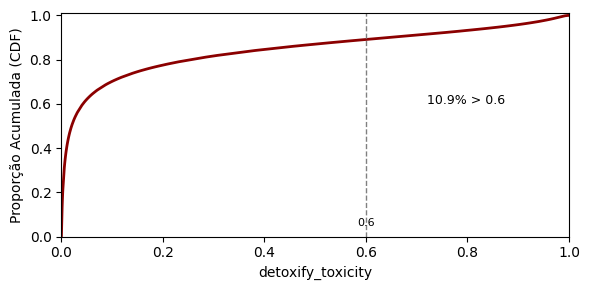

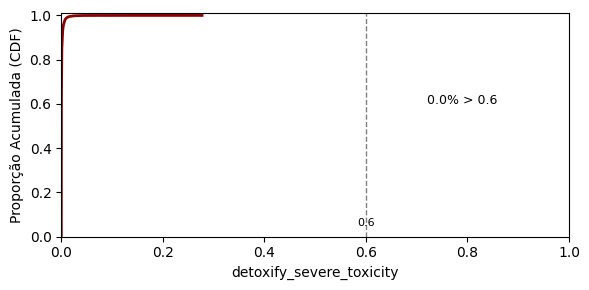

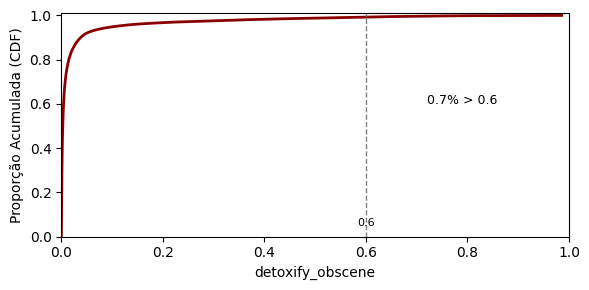

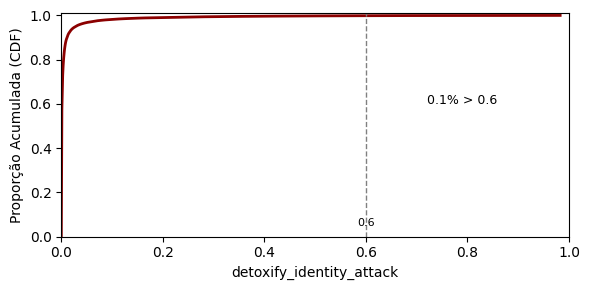

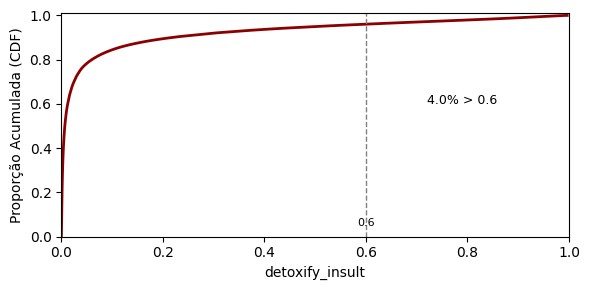

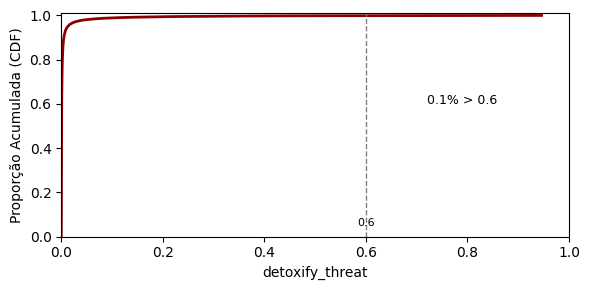

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_toxicity_cdf(df, column):
    # 1. Pega a coluna de toxicidade de todos os vídeos
    toxicity_scores = df[column].dropna().values

    # 2. Ordena os valores em ordem crescente (essencial para CDF)
    sorted_scores = np.sort(toxicity_scores)

    # 3. Cria os valores acumulados (proporção)
    cdf = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores)

    # 4. Cria o gráfico
    plt.figure(figsize=(6, 3))
    plt.plot(sorted_scores, cdf, color='darkred', lw=2, label='CDF')

    # 5. Adiciona linha vertical no ponto 0.6
    plt.axvline(x=0.6, color='gray', linestyle='--', lw=1)
    plt.text(0.6, 0.05, '0.6', ha='center', fontsize=8)

    # 6. Calcula e mostra % de vídeos com toxicidade > 0.6
    perc_above = np.sum(toxicity_scores > 0.6) / len(toxicity_scores) * 100
    plt.text(0.72, 0.6, f'{perc_above:.1f}% > 0.6', color='black', fontsize=9)

    # 7. Formatações finais
    plt.xlabel(column)
    plt.ylabel("Proporção Acumulada (CDF)")
    plt.grid(False)
    plt.ylim(0, 1.01)
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

for column in ['detoxify_toxicity', 'detoxify_severe_toxicity', 'detoxify_obscene', 'detoxify_identity_attack', 'detoxify_insult', 'detoxify_threat']:
  plot_toxicity_cdf(df_videos, column)


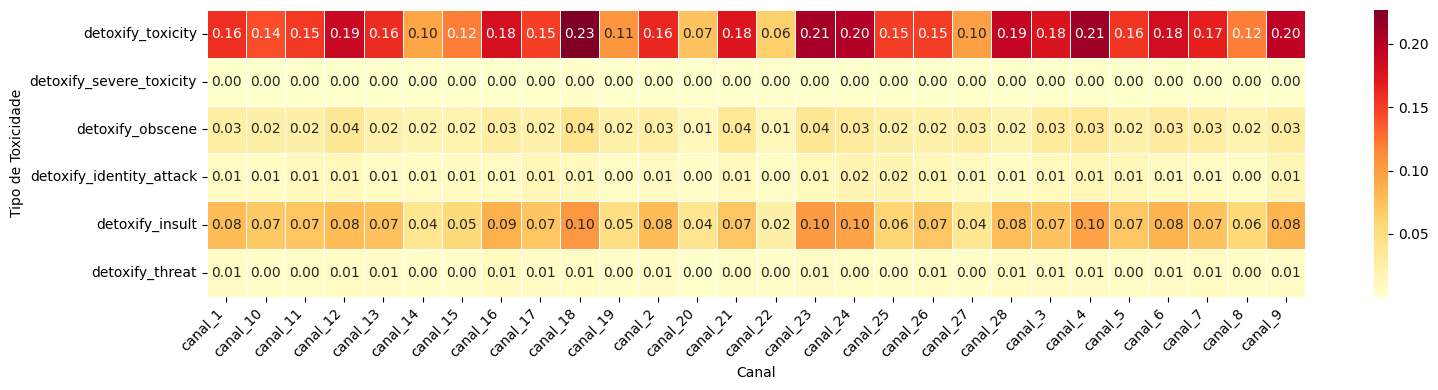

In [ ]:
import seaborn as sns

tox_cols = ['detoxify_toxicity', 'detoxify_severe_toxicity', 'detoxify_obscene', 'detoxify_identity_attack', 'detoxify_insult', 'detoxify_threat']

# Agrupamento: média por canal para cada tipo de toxicidade
channel_tox = df_videos.groupby('id_canal_anonimizado')[tox_cols].mean().T  # Transpõe para linhas = tipos, colunas = canais

# Heatmap
plt.figure(figsize=(16, 4))  # Ajusta o tamanho dinamicamente pelo nº de canais
sns.heatmap(channel_tox, annot=True, fmt=".2f", cmap='YlOrRd', linewidths=0.5)

plt.xlabel("Canal")
plt.ylabel("Tipo de Toxicidade")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


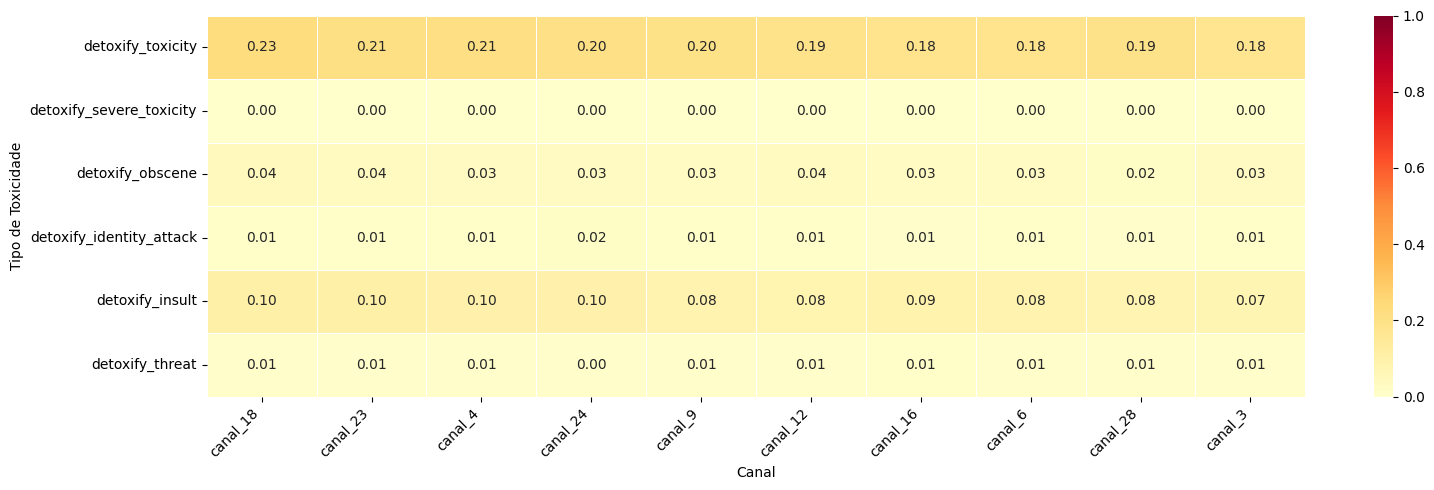

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_media_por_tipo(df):
  # Lista das colunas de toxicidade

  # Número de canais a exibir no heatmap (os mais tóxicos com base na média geral de toxicidade)
  TOP_N = 10

  # Calcula a média de toxicidade por canal para cada categoria
  channel_tox_avg = df.groupby('id_canal_anonimizado')[tox_cols].mean()

  # Ordena os canais pela média geral de toxicidade (ou use outra métrica se preferir)
  channel_tox_avg['media_geral'] = channel_tox_avg.mean(axis=1)
  top_canais = channel_tox_avg.sort_values(by='media_geral', ascending=False).head(TOP_N).drop(columns='media_geral')

  # Transpõe: linhas = tipos de toxicidade, colunas = canais
  channel_tox = top_canais.T

  # Heatmap
  plt.figure(figsize=(1.6 * TOP_N, 5))  # Largura proporcional ao número de canais
  sns.heatmap(channel_tox, annot=True, fmt=".2f", cmap='YlOrRd', linewidths=0.5, vmin=0, vmax=1)

  plt.xlabel("Canal")
  plt.ylabel("Tipo de Toxicidade")
  #plt.title("Média de toxicidade por tipo (Top canais)")
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

plot_media_por_tipo(df_videos)

In [ ]:
tox_cols = ['detoxify_toxicity']

# Calcula média das colunas de toxicidade por canal
media_tox_por_canal = df_videos.groupby('id_canal_anonimizado')[tox_cols].mean().sort_values(by='detoxify_toxicity', ascending=False)

display(media_tox_por_canal.head(10))  # top 10 canais mais tóxicos (média)


,detoxify_toxicity
id_canal_anonimizado,
canal_18,0.226588
canal_4,0.212375
canal_23,0.208722
canal_24,0.202904
canal_9,0.195868
canal_28,0.192268
canal_12,0.189367
canal_6,0.183128
canal_16,0.180883


In [ ]:
def resumo_toxicidade(df):
    total_videos = len(df)

    # Garante que a coluna esteja limpa
    toxicity = df['detoxify_toxicity'].dropna()

    print("🎯 Total de vídeos analisados:", total_videos)
    print("")

    ### 📌 2. PROPORÇÕES POR FAIXAS DE TOXICIDADE ###
    def calc_percent(cond):
        return 100 * cond.sum() / total_videos

    print("📊 Proporções por faixas de toxicidade:")
    print(f"- [0.00]                     : {calc_percent(toxicity == 0):.2f}% (toxicity == 0)")
    print(f"- (0.00 – 0.05]              : {calc_percent((toxicity > 0) & (toxicity <= 0.05)):.2f}%")
    print(f"- (0.05 – 0.2]               : {calc_percent((toxicity > 0.05) & (toxicity <= 0.2)):.2f}%")
    print(f"- (0.2 – 0.5]                : {calc_percent((toxicity > 0.2) & (toxicity <= 0.5)):.2f}%")
    print(f"- (0.5 – 0.7]                : {calc_percent((toxicity > 0.5) & (toxicity <= 0.7)):.2f}%")
    print(f"- (0.7 – 0.9]                : {calc_percent((toxicity > 0.7) & (toxicity <= 0.9)):.2f}%")
    print(f"- (0.9 – 1.0]                : {calc_percent((toxicity > 0.9) & (toxicity <= 1.0)):.2f}%")

    print("")

    ### 📌 3. CONTAGENS ###
    print("🔢 Contagens:")
    print(f"- Total de vídeos           : {total_videos}")
    print(f"- Toxicidade > 0.7          : {(toxicity > 0.7).sum()} vídeos")
    print(f"- Toxicidade > 0.9          : {(toxicity > 0.9).sum()} vídeos")
    print(f"- Toxicidade muito baixa (≤ 0.05): {(toxicity <= 0.05).sum()} vídeos")

resumo_toxicidade(df_videos)

🎯 Total de vídeos analisados: 2238836

📊 Proporções por faixas de toxicidade:
- [0.00]                     : 0.00% (toxicity == 0)
- (0.00 – 0.05]              : 62.01%
- (0.05 – 0.2]               : 15.52%
- (0.2 – 0.5]                : 9.48%
- (0.5 – 0.7]                : 4.12%
- (0.7 – 0.9]                : 4.71%
- (0.9 – 1.0]                : 4.16%

🔢 Contagens:
- Total de vídeos           : 2238836
- Toxicidade > 0.7          : 198636 vídeos
- Toxicidade > 0.9          : 93101 vídeos
- Toxicidade muito baixa (≤ 0.05): 1388314 vídeos


/tmp/ipython-input-3410990527.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_channels.values, y=top_channels.index, palette='Reds_r')


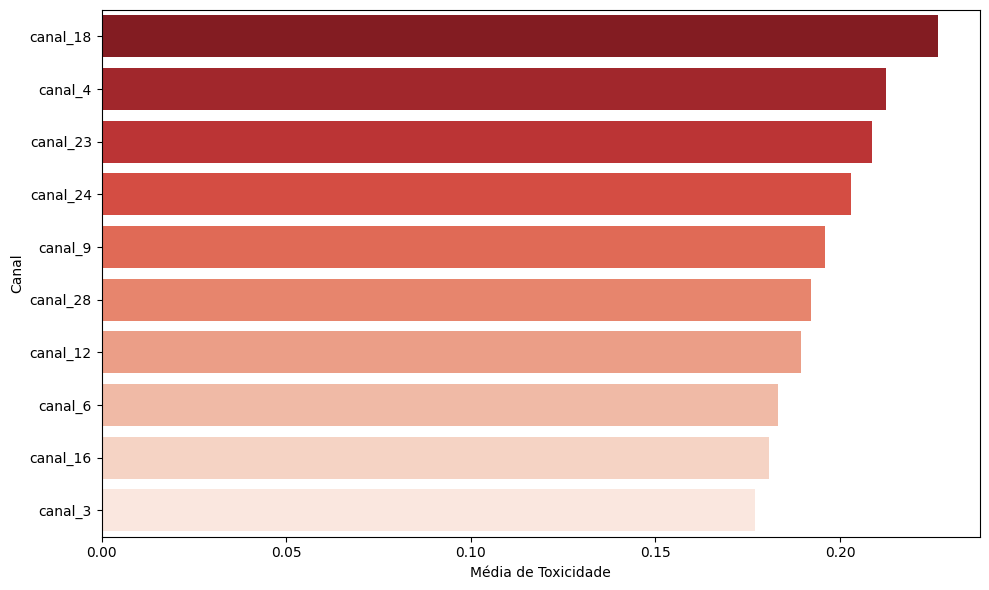

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_toxicity_por_canal(df):
    TOP_N = 10

    # Calcula a média de toxicity por canal
    channel_tox = df.groupby('id_canal_anonimizado')['detoxify_toxicity'].mean()

    # Seleciona os TOP_N canais mais tóxicos
    top_channels = channel_tox.sort_values(ascending=False).head(TOP_N)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_channels.values, y=top_channels.index, palette='Reds_r')
    plt.xlabel("Média de Toxicidade")
    plt.ylabel("Canal")
    #plt.title("Top 10 canais mais tóxicos (média de toxicity)")
    # plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

plot_toxicity_por_canal(df_videos)

## Finetunning do Threshold

### 🧑 Por Canal

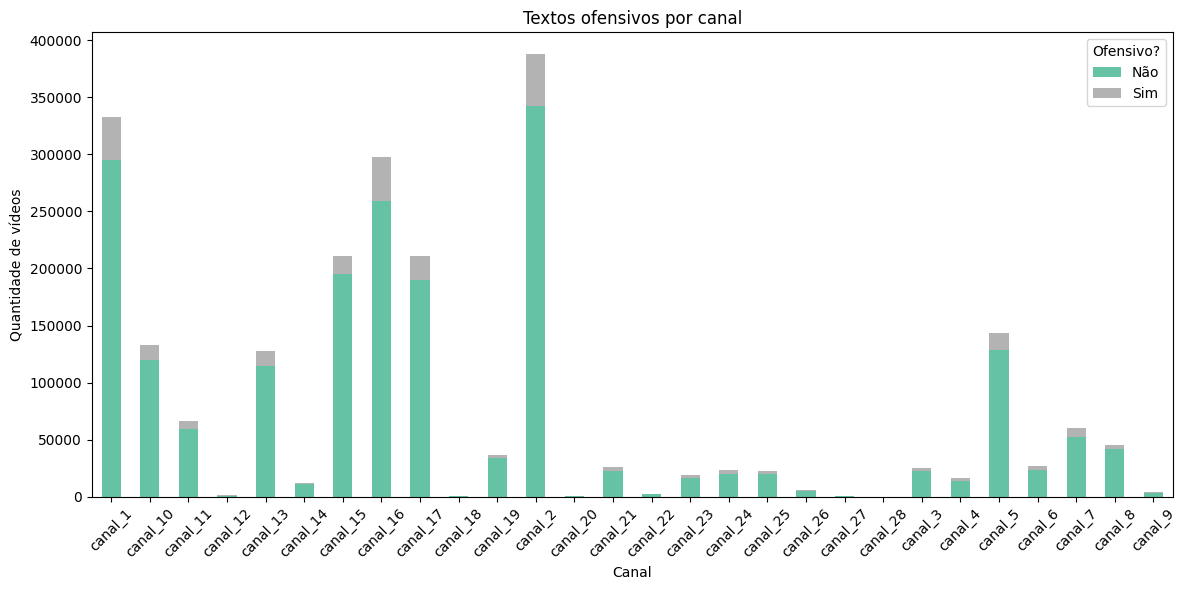

In [ ]:
# df_videos['is_offensive'] = df_videos['toxicity'] > 0.7

offensive_counts = df_videos.groupby('id_canal_anonimizado')['is_misogino'].value_counts().unstack(fill_value=0)

offensive_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
plt.title("Textos ofensivos por canal")
plt.xlabel("Canal")
plt.ylabel("Quantidade de vídeos")
plt.legend(title='Ofensivo?', labels=['Não', 'Sim'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df = df_videos

In [ ]:
counts = df['is_misogino'].value_counts().rename(index={0: 'Não tóxicos', 1: 'Tóxicos'})

print("Contagem de vídeos:")
print(counts)

Contagem de vídeos:
is_misogino
Não tóxicos    1995335
Tóxicos         243501
Name: count, dtype: int64


,is_misogino
id_canal_anonimizado,
canal_2,44869
canal_16,39138
canal_1,37491
canal_17,20918
canal_15,15370
canal_5,14933
canal_13,13166
canal_10,13140
canal_7,7175


,media_is_misogino,total_comentarios
id_canal_anonimizado,,
canal_2,44869,387503
canal_16,39138,297920
canal_1,37491,332305
canal_17,20918,210494
canal_15,15370,210594
canal_5,14933,143482
canal_13,13166,127717
canal_10,13140,132537
canal_7,7175,59881


/tmp/ipython-input-3524452540.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_canais, x=f'media_{col}', y='id_canal_anonimizado', palette='Reds_r')


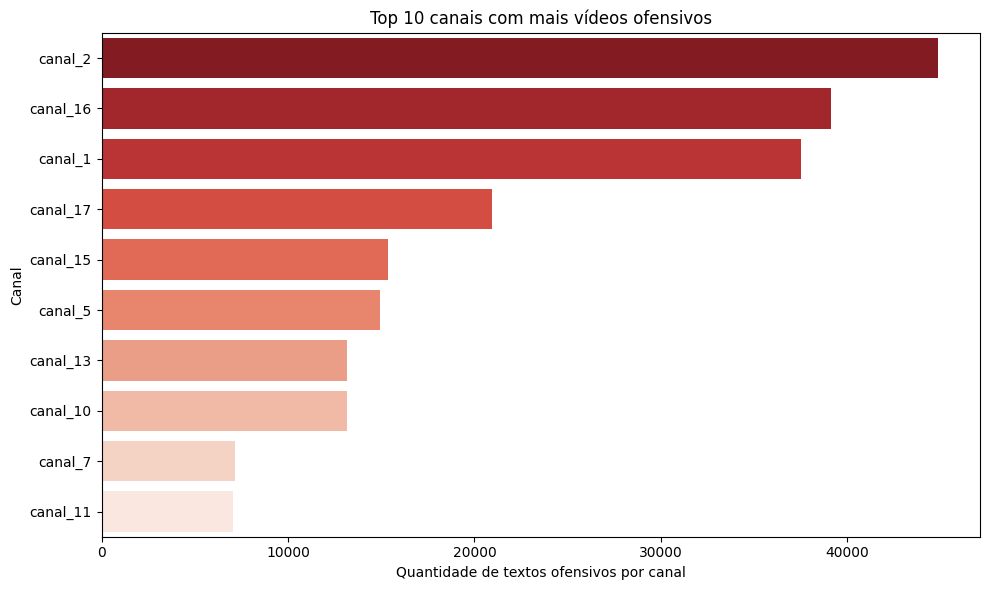

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def pipe(df):
  tox_cols = ['is_misogino']

  # Calcula média das colunas de toxicidade por canal
  media_tox_por_canal = df.groupby('id_canal_anonimizado')[tox_cols].sum().sort_values(by='is_misogino', ascending=False)

  display(media_tox_por_canal.head(10))  # top 10 canais mais tóxicos (média)


  # Suponha que tox_cols já esteja definido, por exemplo:
  # tox_cols = ['toxicity', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']

  # Cria colunas booleanas indicando se o comentário é ofensivo (> 0.7) para cada tipo
  # for col in tox_cols:
  #     df[f'is_misogino_{col}'] = df[col] > 0.7

  # Calcula resumo por canal: média de toxicidade + % ofensivos + total de comentários
  resumo_canal = df.groupby('id_canal_anonimizado').agg(
      {col: 'sum' for col in tox_cols} |
      {f'is_misogino': 'sum' for col in tox_cols} |
      {'text': 'count'}
  ).rename(columns={col: f'media_{col}' for col in tox_cols} |
          {f'is_misogino_{col}': f'porcentagem_ofensivo_{col}' for col in tox_cols} |
          {'text': 'total_comentarios'})

  # Ordena por média de toxicidade (pode mudar para outra variável se quiser)
  resumo_ordenado = resumo_canal.sort_values(by=f'media_{tox_cols[0]}', ascending=False)

  # Mostra o resumo
  display(resumo_ordenado.head(10))


  top_canais = resumo_ordenado.reset_index().head(10)

  for col in tox_cols:
      plt.figure(figsize=(10, 6))
      sns.barplot(data=top_canais, x=f'media_{col}', y='id_canal_anonimizado', palette='Reds_r')
      plt.xlabel(f"Quantidade de textos ofensivos por canal")
      plt.ylabel("Canal")
      plt.title(f"Top 10 canais com mais vídeos ofensivos")
      plt.tight_layout()
      plt.show()

  return resumo_ordenado

resumo_ordenado = pipe(df)

/tmp/ipython-input-502485642.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
/tmp/ipython-input-502485642.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


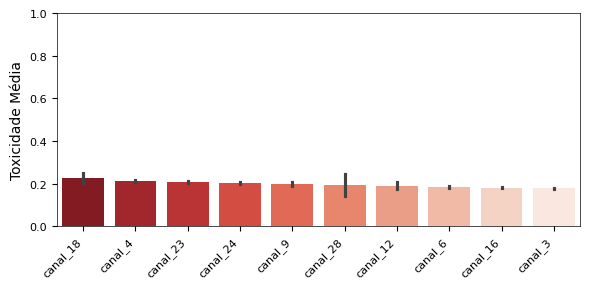

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_toxicity_compact(df):
    TOP_N = 10

    # Calcula a média de toxicidade (score contínuo) por canal
    channel_tox = df.groupby('id_canal_anonimizado')['detoxify_toxicity'].mean()

    # Seleciona os top N canais com maior média de toxicidade
    top_channels = channel_tox.sort_values(ascending=False).head(TOP_N).index

    # Filtra os dados originais para conter apenas os vídeos desses canais
    df_top = df[df['id_canal_anonimizado'].isin(top_channels)]

    # Define a ordem correta para o eixo X
    ordered_channels = channel_tox.loc[top_channels].sort_values(ascending=False).index

    plt.figure(figsize=(6, 3))  # compacto

    sns.barplot(
        data=df_top,
        x='id_canal_anonimizado',
        y='detoxify_toxicity',
        ci=95,  # intervalo de confiança para a média
        palette="Reds_r",
        order=ordered_channels
    )

    plt.ylabel("Toxicidade Média")
    plt.xlabel("")  # omite label para visual mais limpo
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(fontsize=8)
    plt.ylim(0,1)
    plt.grid(False)

    # Personaliza as bordas do gráfico
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)

    plt.tight_layout()
    plt.show()

# Executa a função
plot_toxicity_compact(df_videos)


In [ ]:
df['is_toxico'] = np.where(df_videos['detoxify_toxicity'] > 0.4, 1, 0)

In [ ]:
#df.to_csv(folder_path + 'comentarios_classificados_apos_experimento.csv')

In [ ]:
df.columns

Index(['Unnamed: 0.6', 'Unnamed: 0.5', 'Unnamed: 0.4', 'Unnamed: 0.3',
       'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'text', 'published_at',
       'updated_at', 'like_count', 'viewer_rating', 'can_rate', 'is_reply',
       'parent_id', 'id_video_anonimizado', 'id_canal_anonimizado',
       'id_autor_anonimizado', 'id_comentario_anonimizado', 'emojis',
       'hashtags', 'detoxify_toxicity', 'detoxify_severe_toxicity',
       'detoxify_obscene', 'detoxify_identity_attack', 'detoxify_insult',
       'detoxify_threat', 'detoxify_sexual_explicit', 'guardrail_score',
       'doug_health_score', 'doug_ideology_score', 'doug_insult_score',
       'doug_lgbtqphobia_score', 'doug_other_lifestyle_score',
       'doug_physical_aspects_score', 'doug_profanity_obscene_score',
       'doug_racism_score', 'doug_sexism_score', 'doug_xenophobia_score',
       'is_misogino', 'is_toxico'],
      dtype='object')

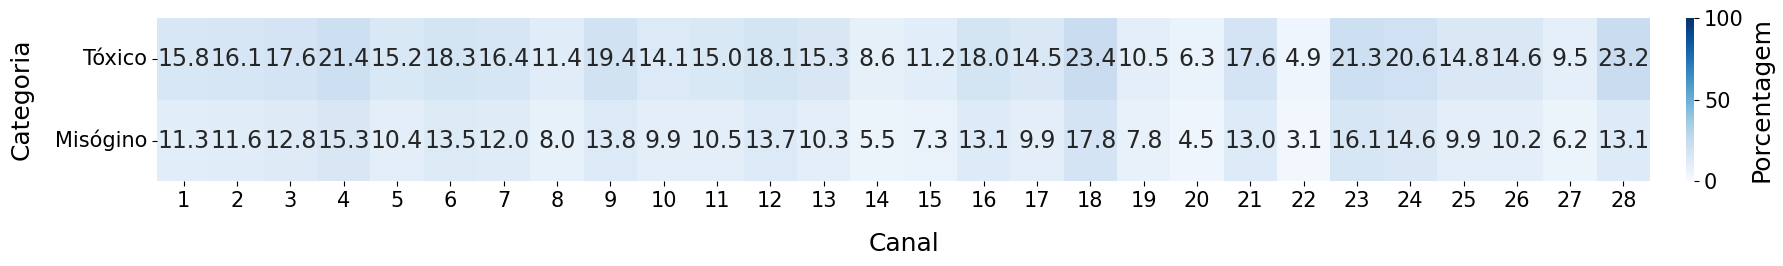

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Atualiza fonte
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 18,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'legend.fontsize': 15,
})

# Usa o DataFrame já carregado
df_roberta = df

# Conta o total de vídeos por canal
total_videos_por_canal = df_roberta.groupby('id_canal_anonimizado').size()

# Soma as flags de toxicidade e misoginia por canal
soma_flags = df_roberta.groupby('id_canal_anonimizado')[['is_toxico', 'is_misogino']].sum()

# Calcula a proporção: quantos são tóxicos/misóginos em relação ao total de vídeos do canal
proporcao_flags = soma_flags.div(total_videos_por_canal, axis=0).T

# Renomeia os índices
proporcao_flags.index = proporcao_flags.index.map({
    'is_toxico': 'Tóxico',
    'is_misogino': 'Misógino'
})

# Ordena os canais pelo número (assumindo o formato "canal_1", "canal_2", etc.)
ordem_canais = sorted(proporcao_flags.columns, key=lambda x: int(x.split('_')[1]))
proporcao_flags = proporcao_flags[ordem_canais]
proporcao_flags.columns = [x.split('_')[1] for x in proporcao_flags.columns]

# Cria o heatmap com proporções (valores entre 0 e 1)
fig, ax = plt.subplots(figsize=(20, 3))

heatmap = sns.heatmap(
    proporcao_flags * 100,  # converte para porcentagem
    annot=True,
    fmt=".1f",  # uma casa decimal
    cmap="Blues",
    vmin=0, vmax=100,
    cbar_kws={'label': 'Porcentagem', 'shrink': 1, 'pad': 0.02},
    linewidths=0.0,
    linecolor='white',
    ax=ax,
    annot_kws={"size": 17}
)

ax.set_xlabel('Canal', labelpad=15)
ax.set_ylabel('Categoria', labelpad=15)

# Rotate y-axis labels
plt.yticks(rotation=0)

colorbar = heatmap.collections[0].colorbar
colorbar.set_ticks([0, 50, 100])  # define mais limiares

plt.subplots_adjust(left=0.05, right=0.92, bottom=0.2, top=0.95)
plt.tight_layout()
plt.show()


In [ ]:
# 17

In [ ]:
def exibir_exemplos(nome, df_exemplo):
    print(f"\n--- {nome} ---")
    for i, row in df_exemplo.iterrows():
        print(f"\nExemplo {i+1}:")
        print(f"Texto: {row['text']}")
        print(f"is_toxico: {row['is_toxico']}, is_misogino: {row['is_misogino']}, canal: {row['id_canal_anonimizado']}")

# Exemplo 1: 5 textos com is_toxico = 1
ex_toxico = df[(df["is_toxico"] == 1) &
                 (df['id_canal_anonimizado'].isin(['canal_4', 'canal_18', 'canal_24', 'canal_28']))].sample(10)
exibir_exemplos("Textos Tóxicos", ex_toxico)

# Exemplo 2: 5 textos com is_misogino = 1
ex_misogino = df[(df["is_misogino"] == 1) &
                 (df['id_canal_anonimizado'].isin(['canal_4', 'canal_18', 'canal_24', 'canal_28']))].sample(10)
exibir_exemplos("Textos Misóginos", ex_misogino)

# Exemplo 3: 5 textos com is_misogino = 1 e is_toxico = 0
ex_misogino_sem_toxico = df[(df["is_misogino"] == 1) &
                            (df["is_toxico"] == 0) &
                            (df['id_canal_anonimizado'].isin(['canal_4', 'canal_18', 'canal_24', 'canal_28']))]
exibir_exemplos("Misóginos sem ser Tóxicos", ex_misogino_sem_toxico)

# Exemplo 4: 5 textos com is_toxico = 1 e is_misogino = 0
ex_toxico_sem_misogino = df[(df["is_toxico"] == 1) &
                            (df["is_misogino"] == 0) &
                            (df['id_canal_anonimizado'].isin(['canal_4', 'canal_18', 'canal_24', 'canal_28']))].sample(10)
exibir_exemplos("Tóxicos sem ser Misóginos", ex_toxico_sem_misogino)


--- Textos Tóxicos ---

Exemplo 131445:
Texto: Que mulherzinha babaca como ela vai provar que isso é assédio e que tipo de assédio
is_toxico: 1, is_misogino: 1, canal: canal_24

Exemplo 2168626:
Texto: Isso é uma empoderada , narcisista , bipolar , intoxicada pelo feminismo .não tem nada de novo , sempre o mesmo bla bla bla  rsrsrs
is_toxico: 1, is_misogino: 1, canal: canal_4

Exemplo 1914409:
Texto: Todos estão carecas de saber o cara que elas se referem , nao se iludao com comentário subjetivo e hipócrita delas!
is_toxico: 1, is_misogino: 1, canal: canal_24

Exemplo 386324:
Texto: O desespero e tanto pra terem sexo que estão apelando que o especial é o cara chupar x*x*t*, aí depois elas usam isso pra botar terror no homem pedindo pix, pra não denunciá-lo a policia. Confia. 1. Amigos busquem provas que a mulher transou com consentimento e antes de ir pro ato sexual vá a delegacia registre um BO, de conjunção carnal consentida, pq se ela for a delegacia registrar BO que foi estupra.. 

In [ ]:
# Exemplo 4: 5 textos com is_toxico = 1 e is_misogino = 0
ex_toxico_sem_misogino = df[(df["detoxify_toxicity"] < 0.05) & (df["is_misogino"] == 0)].sample(50)
exibir_exemplos("Tóxicos sem ser Misóginos", ex_toxico_sem_misogino)



--- Tóxicos sem ser Misóginos ---

Exemplo 1519710:
Texto: A senhorita se encaixa em qual das 3 categorias?
is_toxico: 0, is_misogino: 0, canal: canal_5

Exemplo 1910660:
Texto: 100.000 é melhor que você pode investir e estudar melhorar na sua vida do que mulher qualquer .
is_toxico: 0, is_misogino: 0, canal: canal_1

Exemplo 171078:
Texto: Eu não chego em mulher nenhuma si quiser ficar comigo tem que chegar em min
is_toxico: 0, is_misogino: 0, canal: canal_4

Exemplo 949715:
Texto: Momento Presente. Hey Copini tô aqui. Excelente vídeo 👊🏻
is_toxico: 0, is_misogino: 0, canal: canal_19

Exemplo 324866:
Texto: Se derreteu e finge que não! Hummm!!!
is_toxico: 0, is_misogino: 0, canal: canal_7

Exemplo 1768641:
Texto: As mulheres sempre foram assim, a diferença é que hoje em dia tem internet para mostrar
is_toxico: 0, is_misogino: 0, canal: canal_21

Exemplo 987425:
Texto: A modernete meticulosamente preparou a arapuca,  mas o guerreiro, percebendo o perigo, fugiu rapidamente para as colin

In [ ]:
# Exemplo 4: 5 textos com is_toxico = 1 e is_misogino = 0
ex_toxico_sem_misogino = df[(df["is_toxico"] == 1) & (df["id_canal_anonimizado"] == 'canal_24')]
exibir_exemplos("Tóxicos sem ser Misóginos", ex_toxico_sem_misogino)


Streaming output truncated to the last 5000 lines.

Exemplo 1914214:
Texto: O problema é que elas pensam que só pq são L*ndas e G**tosas , acham que tem muito valor e podem exigir os caras "sarados" e com grana ... Mas pensa bem . Analisem esse meu pensamento como um exemplo , para ver se faz sentido = Pega o homem mais feio do Brasil e vamos supor que ele é servente de pedreiro . Pega uma do Job que é mto top , que cobra 200 ou 300 reais . Isso da um dia e meio de trabalho do cara ... Ela vai dar bjo , fazer o vai-e-vem com o cara e satisfaze-lo sem tanta exigencia ... Agora , para o homem mais f3io do Brasil , não é uma coisa mto difícil conseguir isso , tu imagina para um cara bonito e rico que elas exigem ?
is_toxico: 1, is_misogino: 1, canal: canal_24

Exemplo 1914225:
Texto: A luta das nossa vidas agora é sobreviver ao drex e comprar bitcoin,mulheres não servem mais pra nada além de s*xo!
is_toxico: 1, is_misogino: 0, canal: canal_24

Exemplo 1914228:
Texto: Nao boa ,,ouvir moder

In [ ]:
# Exemplo 4: 5 textos com is_toxico = 1 e is_misogino = 0
ex_toxico_sem_misogino = df[(df["is_misogino"] == 1) & (df["id_canal_anonimizado"] == 'canal_17')].sample(15)
exibir_exemplos("Tóxicos sem ser Misóginos", ex_toxico_sem_misogino)


--- Tóxicos sem ser Misóginos ---

Exemplo 1759111:
Texto: Os manginas são mocinhas enrustidas. Anos de doutrinação feminista fizeram eles agirem exatamente como uma mulher: fazendo shaming😂😂😂 é tão óbvio e patético o comportamento dessas moças, baixa testosterona, birrentos, mimizentos, cheios de manias...são meninas adolescentes
is_toxico: 1, is_misogino: 1, canal: canal_17

Exemplo 1776425:
Texto: kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
is_toxico: 1, is_misogino: 1, canal: canal_17

Exemplo 1609146:
Texto: Esse Lucas é psicanalista e charlatão.Estou aqui pra lembrar: procurem sempre um psicólogo da linha comportamental. Não caiam em balela.
is_toxico: 1, is_misogino: 1, canal: canal_17

Exemplo 2023239:
Texto: A loucura feminista contaminou as mulheres mesmo kkkkkk
is_toxico: 1, is_misogino: 1, canal: canal_17

Exemplo 1676947:
Texto: So se ferra quem quer, e so NAO ser emocionado ignorante e Fazer Uma Vasectomia q custa menos de 4 mil e dura menos de meia hora Sem Riscos , e melho

In [ ]:
# Exemplo 4: 5 textos com is_toxico = 1 e is_misogino = 0
ex_toxico_sem_misogino = df[(df["id_canal_anonimizado"] == 'canal_24')].sample()
exibir_exemplos("Tóxicos sem ser Misóginos", ex_toxico_sem_misogino)


--- Tóxicos sem ser Misóginos ---

Exemplo 306392:
Texto: A pergunta é, para o reality, isso não é agressão psicológica contra o cara não, coagindo o cara, se ele tentar afastar ela pq ela tá se aproximando de mais dele, ele vai ser acusado de novo de agressor, não tem lógica, que lei de merda. Nem vou comentar mais nada, se não sou machista.
is_toxico: 1, is_misogino: 1, canal: canal_24


In [ ]:
# Exemplo 4: 5 textos com is_toxico = 1 e is_misogino = 0
ex_toxico_sem_misogino = df[(df["is_misogino"] == 1) & (df["id_canal_anonimizado"] == 'canal_10')].sample(5)
exibir_exemplos("Tóxicos sem ser Misóginos", ex_toxico_sem_misogino)


--- Tóxicos sem ser Misóginos ---

Exemplo 227794:
Texto:  -p7k Mesma coisa que eu dizer que ALIENS nunca destruíram castelos medievais e tu dizer que é só uma conjectura KKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKKK
is_toxico: 1, is_misogino: 1, canal: canal_10

Exemplo 834731:
Texto: Olhar de mil rolas é de foder kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
is_toxico: 1, is_misogino: 1, canal: canal_10

Exemplo 955570:
Texto: Se essa dupla é o epítome da inteligência brasileira, então estamos ferrados mesmo.
is_toxico: 1, is_misogino: 1, canal: canal_10

Exemplo 178928:
Texto: Porra Brigadeiro, se quer guerra. Se candidata e acha quem te apoia e faz.
is_toxico: 1, is_misogino: 1, canal: canal_10

Exemplo 230027:
Texto: Contribui em MUITO com asneiras...kkkk
is_toxico: 1, is_misogino: 1, canal: canal_10


In [ ]:
# Exemplo 4: 5 textos com is_toxico = 1 e is_misogino = 0
ex_toxico_sem_misogino = df[(df["is_misogino"] == 1) & (df["id_canal_anonimizado"] == 'canal_9')].sample(5)
exibir_exemplos("Tóxicos sem ser Misóginos", ex_toxico_sem_misogino)


--- Tóxicos sem ser Misóginos ---

Exemplo 2071485:
Texto: Quanto mais se acham, quanto mais se auto-elogiam, mais soberbas e mais repugnantes elas são. Imagina conviver com uma pessoa dessas.
is_toxico: 1, is_misogino: 1, canal: canal_9

Exemplo 461894:
Texto: Tatoo, piercing, pintura é 3P: Palhaça, Pirata ou Prostituta😂
is_toxico: 1, is_misogino: 1, canal: canal_9

Exemplo 146510:
Texto: vai trabalhar coroa, so trouxa, escravoceta que paga conta pra capivara.
is_toxico: 1, is_misogino: 1, canal: canal_9

Exemplo 480136:
Texto: aqui nós vemos a atuação conjunta das duas matrix ..muito homem preso em uma ou em outra ou nas duas ...É preciso se libertar dessa porra toda ai
is_toxico: 1, is_misogino: 1, canal: canal_9

Exemplo 427964:
Texto: kkkkkkk calma! é melhor deixar elas mesmas se matam com inveja e mentiras!
is_toxico: 1, is_misogino: 1, canal: canal_9


In [ ]:
# Exemplo 4: 5 textos com is_toxico = 1 e is_misogino = 0
ex_toxico_sem_misogino = df[(df["is_toxico"] == 1) | (df["is_misogino"] == 1)].sample(30)
exibir_exemplos("Tóxicos sem ser Misóginos", ex_toxico_sem_misogino)


--- Tóxicos sem ser Misóginos ---

Exemplo 1094458:
Texto: Elas trocam "favores" por dinheiro, não querem trabalhar. Parasitar um "sugar daddy" é mais fácil.
is_toxico: 1, is_misogino: 1, canal: canal_2

Exemplo 223706:
Texto: @  Na tua bíblia idiota deus manda matar crianças, diz como um escravo deve ser espancado ou morto, diz que pessoas com defeito físico são impuras, diz que incrédulos devem ser mortos, que se alguém te convidar para outra religião você tem a obrigação de matá-la. Já li esse livro escroto. Tem muito mais idiotices nessa porcaria. Vocês sabem disso, mas preferem fazer de conta que não há cretinices.
is_toxico: 1, is_misogino: 1, canal: canal_2

Exemplo 162260:
Texto: A mina digito o celular dela com 2 cliques, wtf
is_toxico: 1, is_misogino: 1, canal: canal_1

Exemplo 1112759:
Texto: Esse povo de esquerda que vive cagando regra e sempre cancelando as pessoas tem mais é que sofrer na pele tudo aquilo que eles militam.
is_toxico: 1, is_misogino: 0, canal: canal_13

E

In [ ]:
df_videos = pd.read_csv(folder_path + 'videos_classificados_apos_experimento.csv')

import pandas as pd
from scipy.stats import spearmanr

# Exemplo: df_videos e df_comentarios já carregados
# Ambos têm: id_canal_anonimizado, is_misogino (0/1)
# df_comentarios também deve ter o id_canal_anonimizado associado ao comentário

# 1️⃣ Calcular % de vídeos misóginos por canal
perc_videos = (
    df_videos.groupby('id_canal_anonimizado')['is_misogino']
    .mean()
    .reset_index(name='perc_video_misogino')
)

# 2️⃣ Calcular % de comentários misóginos por canal
perc_coments = (
    df.groupby('id_canal_anonimizado')['is_misogino']
    .mean()
    .reset_index(name='perc_coment_misogino')
)

# 3️⃣ Juntar as duas tabelas
df_percent = pd.merge(perc_videos, perc_coments, on='id_canal_anonimizado', how='inner')

# 4️⃣ Calcular correlação de Spearman
corr, p_value = spearmanr(df_percent['perc_video_misogino'], df_percent['perc_coment_misogino'])

print("==== Resultados ====")
print(df_percent)
print(f"Correlação de Spearman: {corr:.4f}")
print(f"p-valor: {p_value:.4f}")


==== Resultados ====
   id_canal_anonimizado  perc_video_misogino  perc_coment_misogino
0               canal_1             0.001874              0.112821
1              canal_10             0.032440              0.099142
2              canal_11             0.000000              0.105322
3              canal_12             0.000000              0.137386
4              canal_13             0.000000              0.103087
5              canal_14             0.000000              0.055064
6              canal_15             0.002208              0.072984
7              canal_16             0.000000              0.131371
8              canal_17             0.051220              0.099376
9              canal_18             0.003012              0.178207
10             canal_19             0.006645              0.077683
11              canal_2             0.004122              0.115790
12             canal_20             0.003509              0.045045
13             canal_21             0.020

In [ ]:
import pandas as pd
from scipy.stats import spearmanr

# 1️⃣ Calcular % de vídeos tóxicos por canal
perc_videos = (
    df_videos.groupby('id_canal_anonimizado')['is_toxico']
    .mean()
    .reset_index(name='perc_video_toxico')
)

# 2️⃣ Calcular % de comentários tóxicos por canal
perc_coments = (
    df.groupby('id_canal_anonimizado')['is_toxico']
    .mean()
    .reset_index(name='perc_coment_toxico')
)

# 3️⃣ Juntar as duas tabelas
df_percent = pd.merge(perc_videos, perc_coments, on='id_canal_anonimizado', how='inner')

# 4️⃣ Calcular correlação de Spearman
corr, p_value = spearmanr(df_percent['perc_video_toxico'], df_percent['perc_coment_toxico'])

# 5️⃣ Exibir resultados
print("==== Resultados ====")
print(df_percent)
print(f"Correlação de Spearman: {corr:.4f}")
print(f"p-valor: {p_value:.4f}")


==== Resultados ====
   id_canal_anonimizado  perc_video_toxico  perc_coment_toxico
0               canal_1           0.004686            0.157623
1              canal_10           0.074753            0.140610
2              canal_11           0.002878            0.150190
3              canal_12           0.005000            0.180683
4              canal_13           0.007407            0.152775
5              canal_14           0.000000            0.086267
6              canal_15           0.013245            0.111660
7              canal_16           0.002232            0.179709
8              canal_17           0.158537            0.145078
9              canal_18           0.003012            0.233825
10             canal_19           0.029900            0.105147
11              canal_2           0.015901            0.160856
12             canal_20           0.003509            0.063063
13             canal_21           0.029046            0.176171
14             canal_22           